In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys
sys.path.append('/tmp/local_scratch/v_neelesh_bisht/3d-cnn/')

import matplotlib.pyplot as plt
import numpy as np
import torch

from config import ResnetConfig
from dataset import ImageDataset, MaskDataset
from utils import CommonUtils, Device
from cams.resnet_cams import GradCam, DiffCAM, CounterFactual
from models import Resnet3D

In [8]:
print(torch.cuda.device_count())
torch.cuda.empty_cache()
config = ResnetConfig()
config.phase = 'test'
config.gpu_id = [3]

# get device for processing
device_obj = Device()
device_obj.set_device(config.gpu_id[0])
device = device_obj.get_device()
print(f"Using device: {device}")

8
Using device: cuda:3


In [9]:
# get test data and mask data

output_dir = os.path.join(os.getcwd(), "MosMedData")
os.makedirs(output_dir, exist_ok=True)

test_scan_paths = [os.path.join(output_dir, "CT-1", x) for x in sorted(os.listdir(os.path.join(output_dir, "CT-1")))]
mask_scan_paths = [os.path.join(output_dir, "mask", x) for x in sorted(os.listdir(os.path.join(output_dir, "mask")))]
test_scan_paths = test_scan_paths[0:3]
mask_scan_paths = mask_scan_paths[0:3]
x_test = np.array([ImageDataset.process_image(path) for path in test_scan_paths])
y_test = np.array([1 for _ in range(len(test_scan_paths))])

print('Number of samples in test are %d' % (x_test.shape[0]))
test_sample = x_test[2] # width, height, depth
test_tensor = torch.tensor(test_sample).permute(2, 1, 0) # depth, height, width

masks = np.array([MaskDataset.process_mask(path) for path in mask_scan_paths])
mask_test_volume = masks[2]

Number of samples in test are 3


In [10]:
model, parameters = Resnet3D.generate_model(config) 
model.load_state_dict(torch.load(config.model_path, map_location=device))
print(model)

DataParallel(
  (module): ResNet(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64,

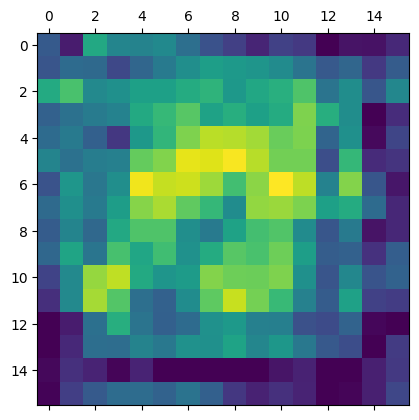

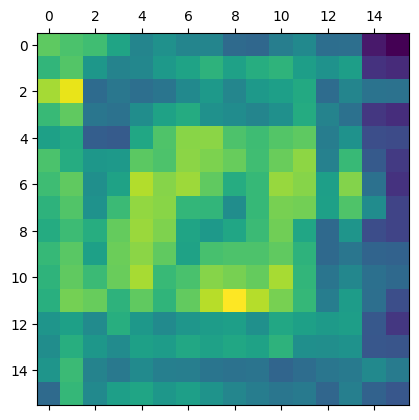

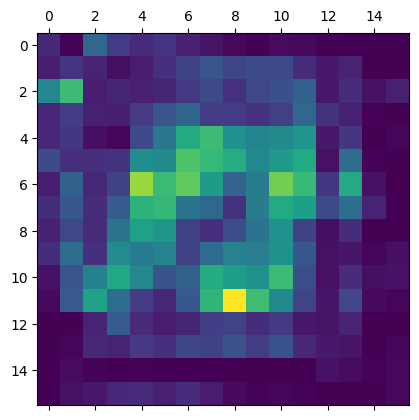

In [11]:
last_conv_layer_name = 'layer4'
sample = test_tensor.unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)

target_class_idx = 1  # Target class
ref_class_idx = 0  # Reference class


# Generate grad and diff-grad class activation heatmap
grad_cam_heatmap, _,  diff_grad_cam_heatmap= GradCam.compute(sample, model, last_conv_layer_name, target_class_idx, ref_class_idx)
plt.matshow(np.squeeze(grad_cam_heatmap[:, :, 3]))
plt.show()

# Generate diff class activation heatmap
diff_cam_heatmap = DiffCAM.make_diffcam_heatmap(sample, model, target_class_idx, ref_class_idx)
plt.matshow(np.squeeze(diff_cam_heatmap[:, :, 3]))
plt.show()


#Generate counter factual heatmap
counter_factual_heatmap = CounterFactual.make_counter_factual_heatmap(sample, model, target_class_idx, ref_class_idx)
plt.matshow(np.squeeze(counter_factual_heatmap[:, :, 3]))
plt.show()


# Resize heatmap
grad_cam_heatmap = CommonUtils.get_resized_heatmap(grad_cam_heatmap, test_sample.shape)
diff_grad_cam_heatmap = CommonUtils.get_resized_heatmap(diff_grad_cam_heatmap, test_sample.shape)
diff_cam_heatmap = CommonUtils.get_resized_heatmap(diff_cam_heatmap, test_sample.shape)
counter_factual_heatmap = CommonUtils.get_resized_heatmap(counter_factual_heatmap, test_sample.shape)

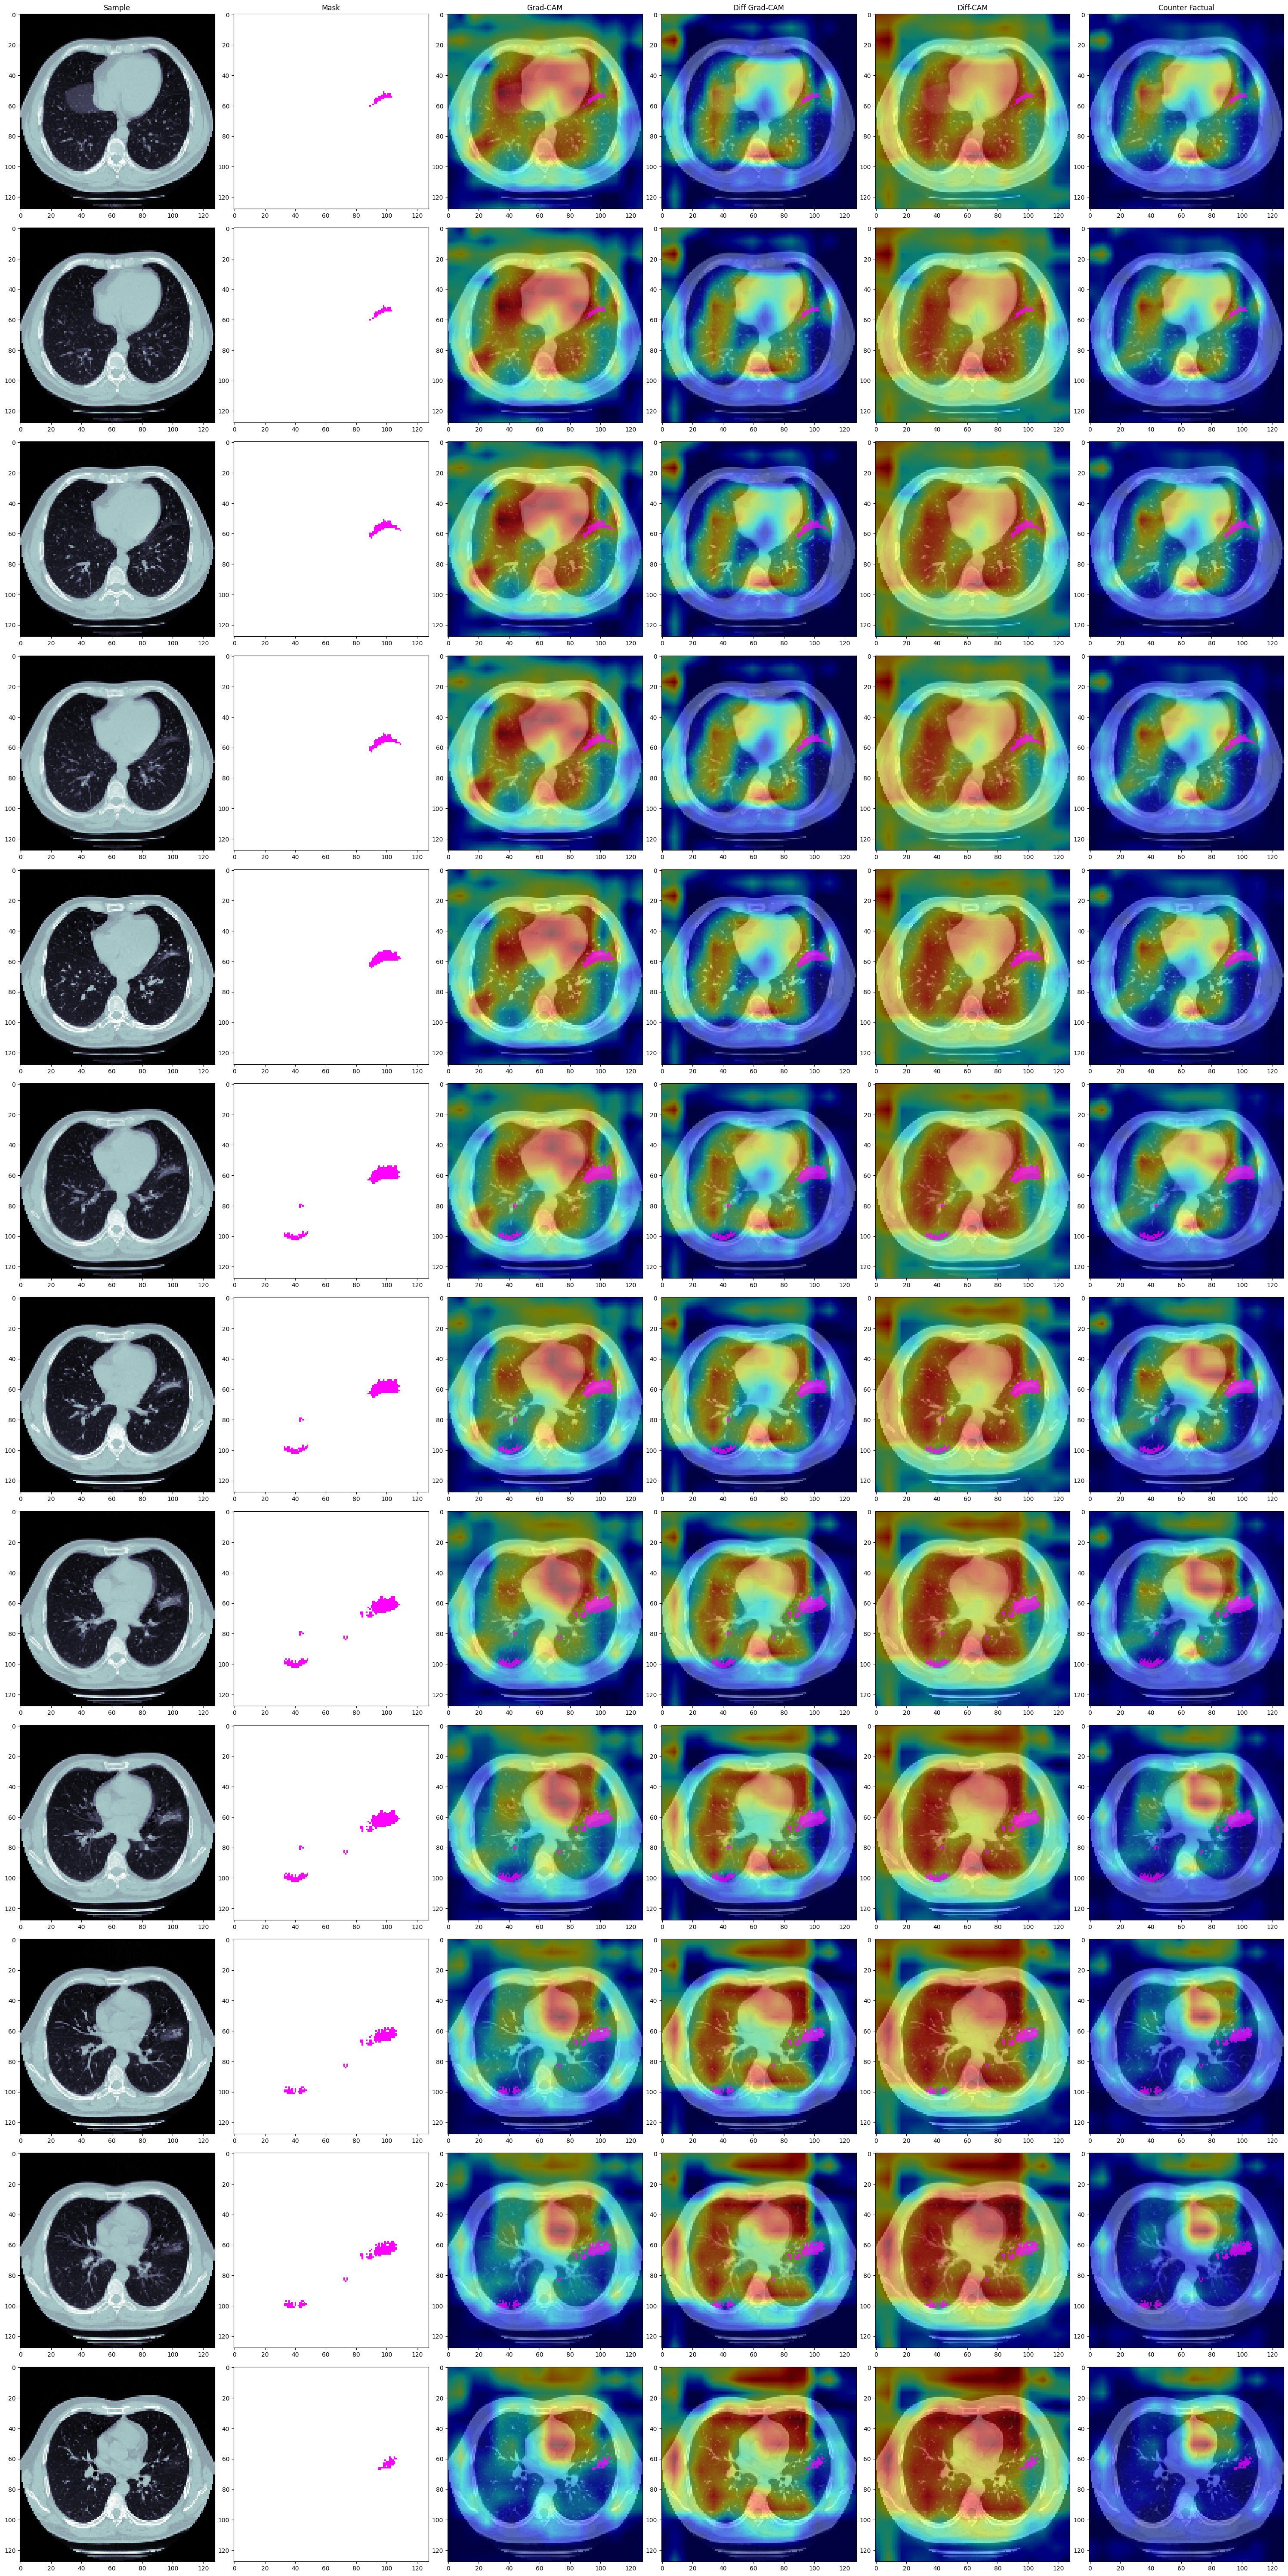

In [12]:
#TODO move to MaskDataset normalization function
# Assuming mask values are 0 and 1, convert to yellow (1) and black (0)
mask_test = np.where(np.abs(mask_test_volume) < 1e-15, 0, 1)
 # Set non-1 values to NaN for transparency
mask_test = np.where(mask_test == 1, 1, np.nan) 

indices = np.where(mask_test == 1)
indices_list = list(zip(*indices))
arr = [i[2] for i in indices_list]

# Find the range of the slices
min_slice = np.min(np.unique(arr))
max_slice = np.max(np.unique(arr))

# Create a single figure with subplots
fig, ax = plt.subplots(max_slice - min_slice + 1, 6, figsize=(30, 5 * (max_slice - min_slice + 1)))

# Loop through each slice and plot the images in the appropriate subplot
for i in range(min_slice, max_slice + 1):
    slice_idx = i - min_slice

    # Adding titles for the first row
    if slice_idx == 0:
        ax[slice_idx, 0].set_title('Sample')
        ax[slice_idx, 1].set_title('Mask')
        ax[slice_idx, 2].set_title('Grad-CAM')
        ax[slice_idx, 3].set_title('Diff Grad-CAM')
        ax[slice_idx, 4].set_title('Diff-CAM')
        ax[slice_idx, 5].set_title('Counter Factual')

    ax[slice_idx, 0].imshow(np.squeeze(test_sample[:, :, i]), origin='upper', cmap='bone')
    ax[slice_idx, 1].imshow(np.squeeze(mask_test[:, :, i]), origin='upper', cmap='spring')

    img3 = ax[slice_idx, 2].imshow(np.squeeze(test_sample[:, :, i]), cmap='bone')
    img4 = ax[slice_idx, 2].imshow(np.squeeze(grad_cam_heatmap[:, :, i]), cmap='jet', alpha=0.5, extent=img3.get_extent())
    img5 = ax[slice_idx, 2].imshow(np.squeeze(mask_test[:, :, i]), cmap='spring', alpha=0.7, extent=img3.get_extent())

    img6 = ax[slice_idx, 3].imshow(np.squeeze(test_sample[:, :, i]), cmap='bone')
    img7 = ax[slice_idx, 3].imshow(np.squeeze(diff_grad_cam_heatmap[:, :, i]), cmap='jet', alpha=0.5, extent=img6.get_extent())
    img8 = ax[slice_idx, 3].imshow(np.squeeze(mask_test[:, :, i]), cmap='spring', alpha=0.7, extent=img6.get_extent())

    img9 = ax[slice_idx, 4].imshow(np.squeeze(test_sample[:, :, i]), cmap='bone')
    img10 = ax[slice_idx, 4].imshow(np.squeeze(diff_cam_heatmap[:, :, i]), cmap='jet', alpha=0.5, extent=img9.get_extent())
    img11 = ax[slice_idx, 4].imshow(np.squeeze(mask_test[:, :, i]), cmap='spring', alpha=0.7, extent=img9.get_extent())

    img12 = ax[slice_idx, 5].imshow(np.squeeze(test_sample[:, :, i]), cmap='bone')
    img13 = ax[slice_idx, 5].imshow(np.squeeze(counter_factual_heatmap[:, :, i]), cmap='jet', alpha=0.5, extent=img12.get_extent())
    img14 = ax[slice_idx, 5].imshow(np.squeeze(mask_test[:, :, i]), cmap='spring', alpha=0.7, extent=img12.get_extent())

# Adjust the layout
plt.tight_layout()
plt.show()